# Fossil Data Extraction Baselines

This notebook sets up, runs and evaluates the baseline models for the fossil data extraction task.

The data and baseline approaches are as follows:

| **Entity Name**            | **Baseline Approach**                                              |
|:---:|:---|
| Geographic Location - GEOG | Regular Expressions (Goring et. al 2021)                                      |
| Region Name - REGION           | spaCy Pre-Trained NER model identifying location entities |
| Taxa - TAXA                | In-text search for existing taxa already in Neotoma                |
| Age - AGE                  | Regular Expressions (Goring et. al 2021)                                      |
| Altitude - ALTI            | Regular Expressions ("above sea level", "a.s.l.")                  |
| Email Address(es) - EMAIL  | Regular Expressions                                                |


In [1]:
import os, sys

import re
import pandas as pd
import json
import numpy as np
import spacy
import plotly.express as px

# ensure that the parent directory is on the path for relative imports
sys.path.append(os.path.join(os.path.abspath(''), ".."))

from src.entity_extraction.spacy_entity_extraction import spacy_extract_all

from src.entity_extraction.entity_extraction_evaluation import (
    get_token_labels,
    plot_token_classification_report,
    calculate_entity_classification_metrics,
    visualize_mislabelled_entities
)

%load_ext autoreload
%autoreload 2

## Geographic Location - GEOG

The coordinates of a site are often reported in the literature in a variety of formats. Few varying examples are:
- 402646302N 
- 0795855903W
- 40:26:46.302N 
- 079:58:55.903W
- 40°26′46″N
- 40d 26′ 46″ N
- 40.446195N 
- -79.982195
- 40° 26.7717
- N40:26:46.302
- N40°26′46″
- N40d 26′ 46″
- N40.446195
- 52°05.75′N
- 10°50'E

The baseline solution based off of Goring et. al 2021, which uses regular expressions to identify coordinates. We combine mulitple regex patterns presented in the past work to come up with a pattern which is robust to different formats of the coordinates and reduces the number of false positive string matches compared to the previous work:

1. Pattern for geographic coordinates - ```[-]?[NESW\d]+\s?[NESWd.:°o◦'`"″]\s?[NESW]?\d{1,7}\s?[NESWd.:°o◦′'`"″]?\s?\d{1,6}[[NESWd.:°o◦′'`"″]?\s?\d{0,3}[NESW]?```

In [2]:
 test_sentences = [
    "40:26:46.302N",
    "079:58:55.903W",
    "40°26′46″N",
    "40d 26′ 46″ N",
    "N40:26:46.302",
    "N40°26′46″",
    "N40d 26′ 46″",
    "52°05.75′ N",
    "10°50'E",
    ]

expected_results = [
    [{'start': 0, 'end': 13, 'labels': ['GEOG'], 'text': '40:26:46.302N'}],
    [{'start': 0, 'end': 14, 'labels': ['GEOG'], 'text': '079:58:55.903W'}],
    [{'start': 0, 'end': 10, 'labels': ['GEOG'], 'text': '40°26′46″N'}],
    [{'start': 0, 'end': 13, 'labels': ['GEOG'], 'text': '40d 26′ 46″ N'}],
    [{'start': 0, 'end': 13, 'labels': ['GEOG'], 'text': 'N40:26:46.302'}],
    [{'start': 0, 'end': 10, 'labels': ['GEOG'], 'text': 'N40°26′46″'}],
    [{'start': 0, 'end': 12, 'labels': ['GEOG'], 'text': 'N40d 26′ 46″'}],
    [{'start': 0, 'end': 11, 'labels': ['GEOG'], 'text': '52°05.75′ N'}],
    [{'start': 0, 'end': 7, 'labels': ['GEOG'], 'text': "10°50'E"}]
]

In [3]:
for i, sentence in enumerate(test_sentences):

    extracted_geographic_coordinates = extract_geographic_coordinates(sentence)

    print(f"Testing sentence: {sentence}")
    print(f"Got: {extracted_geographic_coordinates}\n")
    assert extracted_geographic_coordinates == expected_results[i]

Testing sentence: 40:26:46.302N
Got: [{'start': 0, 'end': 13, 'labels': ['GEOG'], 'text': '40:26:46.302N'}]

Testing sentence: 079:58:55.903W
Got: [{'start': 0, 'end': 14, 'labels': ['GEOG'], 'text': '079:58:55.903W'}]

Testing sentence: 40°26′46″N
Got: [{'start': 0, 'end': 10, 'labels': ['GEOG'], 'text': '40°26′46″N'}]

Testing sentence: 40d 26′ 46″ N
Got: [{'start': 0, 'end': 13, 'labels': ['GEOG'], 'text': '40d 26′ 46″ N'}]

Testing sentence: N40:26:46.302
Got: [{'start': 0, 'end': 13, 'labels': ['GEOG'], 'text': 'N40:26:46.302'}]

Testing sentence: N40°26′46″
Got: [{'start': 0, 'end': 10, 'labels': ['GEOG'], 'text': 'N40°26′46″'}]

Testing sentence: N40d 26′ 46″
Got: [{'start': 0, 'end': 12, 'labels': ['GEOG'], 'text': 'N40d 26′ 46″'}]

Testing sentence: 52°05.75′ N
Got: [{'start': 0, 'end': 11, 'labels': ['GEOG'], 'text': '52°05.75′ N'}]

Testing sentence: 10°50'E
Got: [{'start': 0, 'end': 7, 'labels': ['GEOG'], 'text': "10°50'E"}]



## Region Name - REGION

We can use pretrained ner models to extract location names from literature. For the baseline approach, we do not try to differentiate between `site names` and `region names` for the site and consider all the entities to be of type `REGION`.

In [4]:
 test_sentences = [
    "Its relevance to northwestern Europe in the Late Quaternary Period ( H. NICHOLS -)231 Chronology of Postglacial pollen profiles in the Pacific Northwest ( U.S.A. )",
    "The scenery around Garibaldi lake is pristine",
    "This movie was shot in the old towns of Europe",
    "Philosophical Transactions of and tbe pollen record in the British Isles, In : Birks HH, Birks HJb, Kaland PE, Moe D, eds.",
    "Holocene fluctuations of cold climate in the Swiss Alps ( H. ZOLLER -)"
]

expected_results = [
    [{'start': 30, 'end': 36, 'labels': ['REGION'], 'text': 'Europe'}, {'start': 131, 'end': 152, 'labels': ['REGION'], 'text': 'the Pacific Northwest'}],
    [{'start': 19, 'end': 33, 'labels': ['REGION'], 'text': 'Garibaldi lake'}],
    [{'start': 40, 'end': 46, 'labels': ['REGION'], 'text': 'Europe'}],
    [{'start': 55, 'end': 72, 'labels': ['REGION'], 'text': 'the British Isles'}],
    [{'start': 41, 'end': 55, 'labels': ['REGION'], 'text': 'the Swiss Alps'}]
]

In [5]:
for i, sentence in enumerate(test_sentences):

    extracted_region_names = extract_region_names(sentence)
    print(f"Testing sentence: {sentence}")
    print(f"Got: {extracted_region_names}\n")
    assert extracted_region_names == expected_results[i]

Testing sentence: Its relevance to northwestern Europe in the Late Quaternary Period ( H. NICHOLS -)231 Chronology of Postglacial pollen profiles in the Pacific Northwest ( U.S.A. )
Got: [{'start': 30, 'end': 36, 'labels': ['REGION'], 'text': 'Europe'}, {'start': 131, 'end': 152, 'labels': ['REGION'], 'text': 'the Pacific Northwest'}]

Testing sentence: The scenery around Garibaldi lake is pristine
Got: [{'start': 19, 'end': 33, 'labels': ['REGION'], 'text': 'Garibaldi lake'}]

Testing sentence: This movie was shot in the old towns of Europe
Got: [{'start': 40, 'end': 46, 'labels': ['REGION'], 'text': 'Europe'}]

Testing sentence: Philosophical Transactions of and tbe pollen record in the British Isles, In : Birks HH, Birks HJb, Kaland PE, Moe D, eds.
Got: [{'start': 55, 'end': 72, 'labels': ['REGION'], 'text': 'the British Isles'}]

Testing sentence: Holocene fluctuations of cold climate in the Swiss Alps ( H. ZOLLER -)
Got: [{'start': 41, 'end': 55, 'labels': ['REGION'], 'text': 'the

## Taxa - TAXA

The baseline approach to extract taxas from full text journal articles is to perform string matching. Using an exhaustive list of all the taxas is present on the neotoma database, we search for the exact taxon names in literature. 

In [6]:
 test_sentences = [
    "Percentage calculation is based on the terrestrial pollen sum from which Betula was excluded KM/1 KM/2 KM/3 NM/1 NM/2 NM/3 NM/4 NM/5 NM/6 NM/7 NM/8",
    "The palaeoecology of an Early Neolithic waterlogged site in northwestern England ( F. OLovmLo -)A pollen-analytical study of cores from the Outer Silver Pit", #False positive
    "Description Salix 0.57 1.76 0.73 13.3 1.67 8.78 1.50 2.88 Solanum dulcamara 0 0 0.73 0 0 1.58 0 0 Lysimachia vulgaris 0 0 4.90 0 0.84 0.53 0 0 Mentha-type 00 0 1.04 0 0 00 Lemna 00 0 7.44 0 1.58 0 0",
    "The first major impacts upon the vegetation record become eident from about 3610 BP with sharp reductions in arboreal taxa, the appearance of cerealtype pollen in L.A.BI, and marked increases in Calluna, Foaceae and Cyperaceae.",
    "The overlying Sphagnum peat is devoid of clastic elements for a short period during which sediment inorganic content declines.",
    "Abstract ) ( A. T. CROSS, G. G. THOMPSON and J. B. ZAITZEFF ) 3 - 1 1 Gymnospermae, general The gymnospermous affinity of Eucommiidites ERDTMAN, 1948"
]

expected_results = [
    [{'start': 73, 'end': 79, 'labels': ['TAXA'], 'text': 'Betula'}],
    [{'start': 146, 'end': 152, 'labels': ['TAXA'], 'text': 'Silver'}], # False positive
    [
        {'start': 12, 'end': 17, 'labels': ['TAXA'], 'text': 'Salix'}, 
        {'start': 58, 'end': 75, 'labels': ['TAXA'], 'text': 'Solanum dulcamara'},
        {'start': 98, 'end': 117, 'labels': ['TAXA'], 'text': 'Lysimachia vulgaris'}, 
        {'start': 143, 'end': 154, 'labels': ['TAXA'], 'text': 'Mentha-type'},
        {'start': 143, 'end': 149, 'labels': ['TAXA'], 'text': 'Mentha'}, 
        {'start': 172, 'end': 177, 'labels': ['TAXA'], 'text': 'Lemna'}],
    [
        {'start': 195, 'end': 202, 'labels': ['TAXA'], 'text': 'Calluna'}, 
        {'start': 216, 'end': 226, 'labels': ['TAXA'], 'text': 'Cyperaceae'}],
    [{'start': 14, 'end': 22, 'labels': ['TAXA'], 'text': 'Sphagnum'}],
    [{'start': 70, 'end': 81, 'labels': ['TAXA'], 'text': 'Gymnosperma'}]
]

In [7]:
for i, sentence in enumerate(test_sentences):

    extracted_taxas = extract_taxa(sentence)

    print(f"Testing sentence: {sentence}")
    print(f"Got: {extracted_taxas}\n")
    assert extracted_taxas == expected_results[i]

Testing sentence: Percentage calculation is based on the terrestrial pollen sum from which Betula was excluded KM/1 KM/2 KM/3 NM/1 NM/2 NM/3 NM/4 NM/5 NM/6 NM/7 NM/8
Got: [{'start': 73, 'end': 79, 'labels': ['TAXA'], 'text': 'Betula'}]

Testing sentence: The palaeoecology of an Early Neolithic waterlogged site in northwestern England ( F. OLovmLo -)A pollen-analytical study of cores from the Outer Silver Pit
Got: [{'start': 146, 'end': 152, 'labels': ['TAXA'], 'text': 'Silver'}]

Testing sentence: Description Salix 0.57 1.76 0.73 13.3 1.67 8.78 1.50 2.88 Solanum dulcamara 0 0 0.73 0 0 1.58 0 0 Lysimachia vulgaris 0 0 4.90 0 0.84 0.53 0 0 Mentha-type 00 0 1.04 0 0 00 Lemna 00 0 7.44 0 1.58 0 0
Got: [{'start': 12, 'end': 17, 'labels': ['TAXA'], 'text': 'Salix'}, {'start': 58, 'end': 75, 'labels': ['TAXA'], 'text': 'Solanum dulcamara'}, {'start': 98, 'end': 117, 'labels': ['TAXA'], 'text': 'Lysimachia vulgaris'}, {'start': 143, 'end': 154, 'labels': ['TAXA'], 'text': 'Mentha-type'}, {'sta

## Age - AGE

The age of samples is often reported in the literature in a variety of formats.  The most common formats are:
- years BP - before present
- kyr BP - 1000’s of years BP
- ka BP - kilo annum BP
- a BP - annum BP
- Ma BP - million years BP
- YBP - years BP

In Neotoma there are three age columns, we have ageold, agetype and ageyoung.

- agetype: Age type or units. Includes the following:
  - Calendar years AD/BC
  - Calendar years BP
  - Calibrated radiocarbon years BP
  - Radiocarbon years BP
  - Varve years BP

The baseline solution based off of Goring et. al 2021 uses regular expressions to:
1. Identify the age entity in the sentence - `" BP "`
2. Determine if it is a range of dates - `"(\\d+(?:[.]\\d+)*) ((?:- {1,2})|(?:to)) (\\d+(?:[.]\\d+)*) ([a-zA-Z]+,BP"`
3. Extract the age entity from the sentence - `"(\\d+(?:[.]\\d+)*),((?:- {1,2})|(?:to)),(\\d+(?:[.]\\d+)*),([a-zA-Z]+,BP),"`

In [8]:
test_sentences = [
    "1234 BP",
    "1234 Ma BP",
    "1234 to 1235 BP",
    "1234 - 1235 BP",
    "1234 -- 1235 BP",
    "1234 BP and 456 to 789 BP",
    "1234 BP and 456 to 789 Ma BP",
    "1234 ka BP",
    "1234 a BP",
    "1234 Ma BP",
    "1234 kyr BP",
    "1234 cal yr BP",
    "1234 YBP",
    "1234 14C BP",
]

expected_results = [
    [{'start': 0, 'end': 7, 'labels': ['AGE'], 'text': '1234 BP'}],
    [{'start': 0, 'end': 10, 'labels': ['AGE'], 'text': '1234 Ma BP'}],
    [{'start': 0, 'end': 15, 'labels': ['AGE'], 'text': '1234 to 1235 BP'}],
    [{'start': 0, 'end': 14, 'labels': ['AGE'], 'text': '1234 - 1235 BP'}],
    [{'start': 0, 'end': 15, 'labels': ['AGE'], 'text': '1234 -- 1235 BP'}],
    [
        {'start': 0, 'end': 7, 'labels': ['AGE'], 'text': '1234 BP'}, 
        {'start': 12, 'end': 25, 'labels': ['AGE'], 'text': '456 to 789 BP'}
    ],
    [
        {'start': 0, 'end': 7, 'labels': ['AGE'], 'text': '1234 BP'}, 
        {'start': 12, 'end': 28, 'labels': ['AGE'], 'text': '456 to 789 Ma BP'}
    ],
    [{'start': 0, 'end': 10, 'labels': ['AGE'], 'text': '1234 ka BP'}],
    [{'start': 0, 'end': 9, 'labels': ['AGE'], 'text': '1234 a BP'}],
    [{'start': 0, 'end': 10, 'labels': ['AGE'], 'text': '1234 Ma BP'}],
    [{'start': 0, 'end': 11, 'labels': ['AGE'], 'text': '1234 kyr BP'}],
    [{'start': 0, 'end': 14, 'labels': ['AGE'], 'text': '1234 cal yr BP'}],
    [{'start': 0, 'end': 8, 'labels': ['AGE'], 'text': '1234 YBP'}],
    [{'start': 0, 'end': 11, 'labels': ['AGE'], 'text': '1234 14C BP'}],
]

In [9]:
# test that all the test sentences are extracted correctly
for i, sentence in enumerate(test_sentences):

    extracted_ages = extract_age(sentence)

    print(f"Testing sentence: {sentence}")
    print(f"Got: {extracted_ages}\n")
    assert extracted_ages == expected_results[i]

Testing sentence: 1234 BP
Got: [{'start': 0, 'end': 7, 'labels': ['AGE'], 'text': '1234 BP'}]

Testing sentence: 1234 Ma BP
Got: [{'start': 0, 'end': 10, 'labels': ['AGE'], 'text': '1234 Ma BP'}]

Testing sentence: 1234 to 1235 BP
Got: [{'start': 0, 'end': 15, 'labels': ['AGE'], 'text': '1234 to 1235 BP'}]

Testing sentence: 1234 - 1235 BP
Got: [{'start': 0, 'end': 14, 'labels': ['AGE'], 'text': '1234 - 1235 BP'}]

Testing sentence: 1234 -- 1235 BP
Got: [{'start': 0, 'end': 15, 'labels': ['AGE'], 'text': '1234 -- 1235 BP'}]

Testing sentence: 1234 BP and 456 to 789 BP
Got: [{'start': 0, 'end': 7, 'labels': ['AGE'], 'text': '1234 BP'}, {'start': 12, 'end': 25, 'labels': ['AGE'], 'text': '456 to 789 BP'}]

Testing sentence: 1234 BP and 456 to 789 Ma BP
Got: [{'start': 0, 'end': 7, 'labels': ['AGE'], 'text': '1234 BP'}, {'start': 12, 'end': 28, 'labels': ['AGE'], 'text': '456 to 789 Ma BP'}]



## Altitude - ALTI

To identify altitude descriptions the primary indicators are:
- "above sea level"
- "a.s.l."
- a single m as the last character after numbers or as a standalone word

In [10]:
test_sentences = [
    "120m above sea level",
    "120m a.s.l.",
    "120 m above sea level",
    "120 m a.s.l.",
    "120m asl",
    "120 m asl",
    "The site was 120m above sea level",
    "The site was 120m a.s.l.",
    "The site was 120 m above sea level",
    "The site was 120 m a.s.l.",
    "First site was 120m asl and the second was 300 m asl",
]

expected_results = [
    [{'start': 0, 'end': 20, 'labels': ['ALTI'], 'text': '120m above sea level'}],
    [{'start': 0, 'end': 11, 'labels': ['ALTI'], 'text': '120m a.s.l.'}],
    [{'start': 0, 'end': 21, 'labels': ['ALTI'], 'text': '120 m above sea level'}],
    [{'start': 0, 'end': 12, 'labels': ['ALTI'], 'text': '120 m a.s.l.'}],
    [{'start': 0, 'end': 8, 'labels': ['ALTI'], 'text': '120m asl'}],
    [{'start': 0, 'end': 9, 'labels': ['ALTI'], 'text': '120 m asl'}],
    [{'start': 13, 'end': 33, 'labels': ['ALTI'], 'text': '120m above sea level'}],
    [{'start': 13, 'end': 24, 'labels': ['ALTI'], 'text': '120m a.s.l.'}],
    [{'start': 13, 'end': 34, 'labels': ['ALTI'], 'text': '120 m above sea level'}],
    [{'start': 13, 'end': 25, 'labels': ['ALTI'], 'text': '120 m a.s.l.'}],
    [
        {'start': 15, 'end': 23, 'labels': ['ALTI'], 'text': '120m asl'},
        {'start': 43, 'end': 52, 'labels': ['ALTI'], 'text': '300 m asl'}
    ]
]

In [11]:
# test that all the test sentences are extracted correctly
for i, sentence in enumerate(test_sentences):

    extracted_altitude = extract_altitude(sentence)

    print(f"Testing sentence: {sentence}")
    print(f"Found: {extracted_altitude}\n")
    assert extracted_altitude == expected_results[i]

Testing sentence: 120m above sea level
Found: [{'start': 0, 'end': 20, 'labels': ['ALTI'], 'text': '120m above sea level'}]

Testing sentence: 120m a.s.l.
Found: [{'start': 0, 'end': 11, 'labels': ['ALTI'], 'text': '120m a.s.l.'}]

Testing sentence: 120 m above sea level
Found: [{'start': 0, 'end': 21, 'labels': ['ALTI'], 'text': '120 m above sea level'}]

Testing sentence: 120 m a.s.l.
Found: [{'start': 0, 'end': 12, 'labels': ['ALTI'], 'text': '120 m a.s.l.'}]

Testing sentence: 120m asl
Found: [{'start': 0, 'end': 8, 'labels': ['ALTI'], 'text': '120m asl'}]

Testing sentence: 120 m asl
Found: [{'start': 0, 'end': 9, 'labels': ['ALTI'], 'text': '120 m asl'}]

Testing sentence: The site was 120m above sea level
Found: [{'start': 13, 'end': 33, 'labels': ['ALTI'], 'text': '120m above sea level'}]

Testing sentence: The site was 120m a.s.l.
Found: [{'start': 13, 'end': 24, 'labels': ['ALTI'], 'text': '120m a.s.l.'}]

Testing sentence: The site was 120 m above sea level
Found: [{'start':

## Email Addresses - EMAIL

There are existing regex patterns developed to identify emails. The one used below was sourced from this StackoverFlow thread: 
- https://stackoverflow.com/questions/201323/how-can-i-validate-an-email-address-using-a-regular-expression

In [12]:
test_sentences = [
    "ty.elgin.andrews@gmail.com",
    "john.smith@aol.com",
    "ty.andrews@student.ubc.ca",
    # from GGD 54b4324ae138239d8684a37b segment 0
    "E-mail addresses : carina.hoorn@milne.cc (C. Hoorn -) mauro.cremaschi@libero.it"
]

expected_results = [
    [{'start': 0, 'end': 26, 'labels': ['EMAIL'], 'text': 'ty.elgin.andrews@gmail.com'}],
    [{'start': 0, 'end': 18, 'labels': ['EMAIL'], 'text': 'john.smith@aol.com'}],
    [{'start': 0, 'end': 25, 'labels': ['EMAIL'], 'text': 'ty.andrews@student.ubc.ca'}],
    [
        {'start': 19, 'end': 40, 'labels': ['EMAIL'], 'text': 'carina.hoorn@milne.cc'},
        {'start': 54, 'end': 79, 'labels': ['EMAIL'], 'text': 'mauro.cremaschi@libero.it'}
    ]
]

In [13]:
for i, sentence in enumerate(test_sentences):

    extracted_emails = extract_email(sentence)

    print(f"Testing sentence: {sentence}")
    print(f"Found: {extracted_emails}\n")
    assert extracted_emails == expected_results[i]

Testing sentence: ty.elgin.andrews@gmail.com
Found: [{'start': 0, 'end': 26, 'labels': ['EMAIL'], 'text': 'ty.elgin.andrews@gmail.com'}]

Testing sentence: john.smith@aol.com
Found: [{'start': 0, 'end': 18, 'labels': ['EMAIL'], 'text': 'john.smith@aol.com'}]

Testing sentence: ty.andrews@student.ubc.ca
Found: [{'start': 0, 'end': 25, 'labels': ['EMAIL'], 'text': 'ty.andrews@student.ubc.ca'}]

Testing sentence: E-mail addresses : carina.hoorn@milne.cc (C. Hoorn -) mauro.cremaschi@libero.it
Found: [{'start': 19, 'end': 40, 'labels': ['EMAIL'], 'text': 'carina.hoorn@milne.cc'}, {'start': 54, 'end': 79, 'labels': ['EMAIL'], 'text': 'mauro.cremaschi@libero.it'}]



# Evaluation of Baseline Methods

Multiple methods to evaluate the NER task are evaluated for a given report:
1. Does the number instances of each category align with what is present in Neotoma?
   1. For each article need to pull out the number of instances of each category for the given DOI/GDD id
2. Does the number of instances of each category align with what has been labelled?
   1. Using the team labelled reports, count the number of instances of each category for each report.
3. Does the extracted locations align with the labelled locations?
   1. This can be done with the Python package `seqeval` which is used to evaluate the performance of a sequence labeling tasks. ([`seqeval` Github](https://github.com/chakki-works/seqeval))

## Loading Raw & Labelled Data

In [2]:
from collections import defaultdict

labelled_file_path = os.path.join(os.getcwd(), os.pardir, "data", "ground_truth")

## Comparison to Neotoma Data

To compare the extraction rate, for each article pull the reported taxa, region names, etc. and compare the extracted values to the reported values.

In [3]:
# TODO

## Comparison of Entity Counts to Labelled Data

In [4]:
import spacy

labelled_files = os.listdir(labelled_file_path)
print(f"Total number of lablled files: {len(labelled_files)}")
# count the number of occurences of each label
annotated_label_counts = defaultdict(int)
spacy_label_counts = defaultdict(int)
spacy.require_gpu()
ner_model = spacy.load(os.path.join(
                        os.pardir,
                        "models",
                        "transformer-v1"))
for index, file in enumerate(labelled_files):
    print(index)
    with open(os.path.join(labelled_file_path, file), "r") as f:
        task = json.load(f)

    raw_text = task['task']['data']['text']
    
    # get the spacy predictions
    spacy_result = spacy_extract_all(raw_text, ner_model)
    for res in spacy_result:
        spacy_label_counts[res['labels'][0]] += 1

    annotation_result = task['result']
    
    for annotation in annotation_result:
        annotated_label_counts[annotation['value']['labels'][0]] += 1

Total number of lablled files: 192
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [5]:
# plot the percentage of entities extracted by baseline vs annotated
annotated_labels = list(annotated_label_counts.keys())
annotated_counts = list(annotated_label_counts.values())

spacy_counts = [spacy_label_counts[label] for label in annotated_labels]

annotated_counts = np.array(annotated_counts)
spacy_counts = np.array(spacy_counts)

# make into a tidy dataframe with columns Label, Source, Count
annotated_df = pd.DataFrame(
    {
        'Label': annotated_labels + annotated_labels,
        'Source': ['Annotated'] * len(annotated_labels) + ['Spacy'] * len(annotated_labels),
        'Count': np.concatenate([annotated_counts, spacy_counts])
    }
)

fig = px.bar(
    annotated_df,
    x="Label",
    y="Count",
    color="Source",
    barmode='group',
    # labels={'x': 'Labels', 'value': 'No. of Entities'},
    title='Counts of Labels in Annotated and Spacy Tras Results',
    width=800,
).update_layout(
    xaxis={'categoryorder': 'total descending'}, 
    margin={'l': 0, 'r': 0, 't': 50, 'b': 0}, 
)

fig.show()

In [6]:
percentage_extracted = spacy_counts / annotated_counts

fig = px.bar(
    x=annotated_labels, 
    y=percentage_extracted, 
    color=annotated_labels,
    labels={'x': 'Labels', 'y': 'Percentage Extracted'},
    title='Percentage of Entities Extracted by Spacy vs Annotated',
    width=800,
    # format the text to show percent
    text=np.round(percentage_extracted*100, 1),
).update_layout(
    xaxis={'categoryorder': 'total descending'},
    margin={'l': 0, 'r': 0, 't': 50, 'b': 0},
    yaxis={'tickformat': ',.0%'},
    showlegend=False,
    yaxis_range=[0, 1.1],
)
fig.show()


## Calculating Precision, Recall and F1 Scores with Seqeval

The python package `seqeval` is used to evaluate the performance of a sequence labeling tasks. ([`seqeval` Github](https://github.com/chakki-works/seqeval)).

It requires the following inputs:
- `y_true` - a list of true labels of each token
- `y_pred` - a list of predicted labels of each token

To take the labelled data from label studio and convert it into the required format, we need to:
1. Load the labelled data
2. Convert the labelled data into a list of lists of labels with 'O' for tokens that are not part of an entity
3. Convert the baseline predictions into a list of lists of labels with 'O' for tokens that are not part of an entity
4. Calculate the precision, recall and f1 scores for each entity type

### Load Labelled Data

In [7]:
labelled_file_path = os.path.join(os.getcwd(), os.pardir, "data", "ground_truth")

In [8]:
def load_json_label_files(labelled_files: str):
    """
    Load the json files containing the labelled data and combines the text
    into a complete text string.

    Parameters
    ----------
    label_files : list
        List of json files containing the labelled data.

    Returns
    -------
    combined_text : str
        The combined text from all the files.
    all_labelled_entities : list
        List of all the labelled entities re-indexed to account for the combined text.

    """

    combined_text = ""
    all_labelled_entities = []
    for file in labelled_files:
        
        with open(os.path.join(labelled_file_path, file), "r") as f:
            task = json.load(f)

        raw_text = task['task']['data']['text']

        annotation_result = task['result']
        labelled_entities = [annotation['value'] for annotation in annotation_result]

        # add the current text length to the start and end indices of labels plus one for the space
        for entity in labelled_entities:
            entity['start'] += len(combined_text)
            entity['end'] += len(combined_text)

        all_labelled_entities += labelled_entities

        # add the current text to the combined text with space in between
        combined_text += raw_text + " "

    return combined_text, all_labelled_entities

### Simplified Test of Evaluation

The following test case is used to test the evaluation of the `seqeval` package. And ensure the steps to wrangle data into the required format are correct.

The expected result is precision/accuracy/recall of 1.0 for all entity types.

In [15]:
import os, json
labelled_files = os.listdir(labelled_file_path)

In [31]:
# check the token labels and indexes match
recall_lst = []
precision_lst = []
all_labelled_tokens = []
all_spacy_tokens = []

for tagged_file in labelled_files:
    text, labelled_entities = load_json_label_files([tagged_file])
    labelled_tokens = get_token_labels(labelled_entities, text)
    
    spacy_entities = spacy_extract_all(text, ner_model)
    spacy_tokens = get_token_labels(spacy_entities, text)
    
    all_labelled_tokens.extend(labelled_tokens[1])
    all_spacy_tokens.extend(spacy_tokens[1])
    
    accuracy, f1, recall, precision = calculate_entity_classification_metrics(
        labelled_tokens = labelled_tokens[1],
        predicted_tokens = spacy_tokens[1],
        method = "tokens"
    )

    if f1 > 0:
        recall_lst.append(recall)
        precision_lst.append(precision)

/home/jenit/yes/envs/fossil_lit/lib/python3.10/site-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/home/jenit/yes/envs/fossil_lit/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/home/jenit/yes/envs/fossil_lit/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



### Entity vs. Token Level Evaluation

The `seqeval` package can be used to evaluate the performance of the NER task at the entity level or the token level. The two approaches are summarized below:

1. **Entity Level Evaluation**
   - The entity level evaluation is the standard approach to evaluating the performance of a NER task. 
   - The evaluation is done at the entity level, meaning that the entire entity must be correctly identified to be considered a true positive.
   - The entity level evaluation is the default evaluation method used by the `seqeval` package.

2. **Token Level Evaluation**
    - The token level evaluation is a more lenient evaluation of the performance of a NER task.
    - The evaluation is done at the token level, meaning that each token must just be of the correct tag (e.g. TAXA) to be considered a true positive.
    - The token level evaluation is not the default evaluation method used by the `seqeval` package and is calculated by turning all Inner (I) tags into Begin (B) tags for labelled data.

Below shows the difference between the two evaluation methods:

In [32]:
accuracy, f1, recall, precision = calculate_entity_classification_metrics(
    labelled_tokens = all_labelled_tokens,  
    predicted_tokens = all_spacy_tokens,
    method = "entities"
)

print(f"Accuracy: {accuracy:.3f}")
print(f"F1: {f1:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precisions: {precision:.3f}")

Accuracy: 0.991
F1: 0.929
Recall: 0.932
Precisions: 0.926


In [33]:
accuracy, f1, recall, precision = calculate_entity_classification_metrics(
    labelled_tokens = all_labelled_tokens,  
    predicted_tokens = all_spacy_tokens,
    method = "tokens"
)

print(f"Accuracy: {accuracy:.3f}")
print(f"F1: {f1:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precisions: {precision:.3f}")

Accuracy: 0.991
F1: 0.939
Recall: 0.946
Precisions: 0.932


#### Evaluation on Simplified Test Data

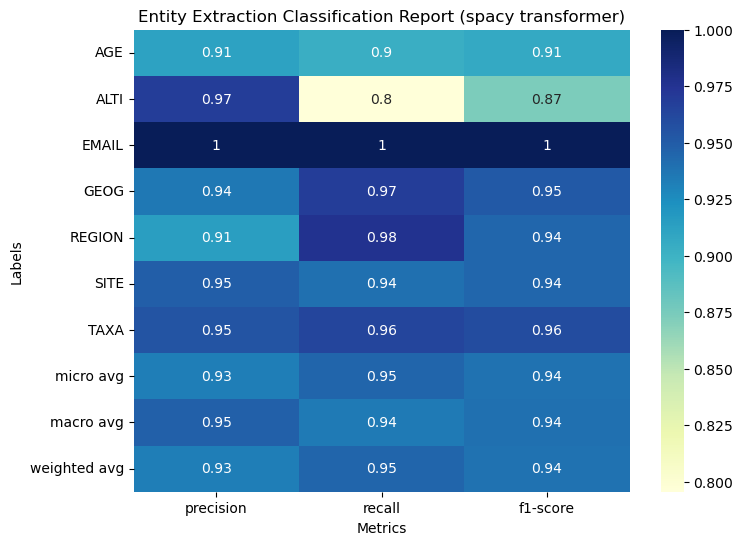

In [36]:
#TODO: Get tokens for test dataset
plot_token_classification_report(
    all_labelled_tokens, 
    all_spacy_tokens, 
    "Entity Extraction Classification Report (spacy transformer) - Train Data",
    method="tokens",
)

## Inspecting Mislabelled Entities

The `spacy` tool `displacy` is used to visualize the entities identified by the baseline model and the labelled entities. This is done to understand the types of entities that are being mislabelled and to identify patterns in the mislabelled entities.

We distinguish between the following types of mislabelled entities:  (set the colors of Red/Orange/Green in the markdown text to match the color)
1. **<font color='red'>False Negatives (Red)</font>** - entities labelled in the labelled data that are not identified by the baseline model
   - these are most important as they signify missed data
2. **<font color='orange'>False Positives (Orange)</font>** - entities identified by the baseline model that are not labelled in the labelled data
   - these are considered less important as they can be rejected by the data steward
3. **<font color='green'>True Positives (Green)</font>** - entities identified by the baseline model that are also labelled in the labelled data

In [37]:
# TODO: Specify a file name and visualize the results

In [ ]:
text = "This is a test age 1234 BP and missed REGION".split(" ")
actual_labels       = ["O", "O", "O",       "O", "O", "B-AGE", "I-AGE", "O", "O", "B-REGION"]
predicted_labels    = ["O", "O", "B-TAXA",  "O", "O", "B-AGE", "I-AGE", "O", "O", "O"]

visualize_mislabelled_entities(actual_labels, predicted_labels, text)

In [ ]:
visualize_mislabelled_entities(labelled_tokens, baseline_tokens, combined_text.split())